In [24]:
from PPM_lib import *

In [5]:
sps=64
y = np.loadtxt('OOK-data-for-eye-diagram-process')
# y = np.loadtxt('4PPM-data-for-eye-diagram-process')
# y = np.loadtxt('8PPM-data-for-eye-diagram-process')
# y = np.loadtxt('16PPM-data-for-eye-diagram-process')

In [6]:
ydata = np.roll(y[128:sps*10000], -sps//2+1)
t = np.kron(np.ones((len(ydata)//sps)//2), np.linspace(-1,1,2*sps, endpoint=False))

### Paso 1 - Separar las amplitudes de las muestras en dos conjuntos

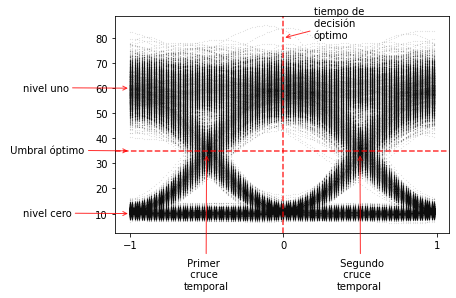

In [23]:
plot(t, 1e5*ydata, '.', color='#0E0E0E', markersize=.3, alpha=.3)

axvline(0,ls='--',color='r', alpha=.8)
axhline(35,ls='--',color='r', alpha=.8)

annotate('tiempo de \ndecisión \nóptimo',xy=(0,80), xytext=(0.2,80), arrowprops=dict(arrowstyle="->", color="r", alpha=0.8))
annotate(' Umbral óptimo',xy=(-1,35), xytext=(-1.8,34), arrowprops=dict(arrowstyle="->", color="r", alpha=0.8))
annotate(' Primer\n  cruce\ntemporal',xy=(-.5,34), xytext=(-.65,-20), arrowprops=dict(arrowstyle="->", color="r", alpha=0.8))
annotate(' Segundo\n  cruce\ntemporal',xy=(.5,34), xytext=(.35,-20), arrowprops=dict(arrowstyle="->", color="r", alpha=0.8))
annotate('nivel cero',xy=(-1,10), xytext=(-1.7,9), arrowprops=dict(arrowstyle="->", color="r", alpha=0.8))
annotate('nivel uno',xy=(-1,60), xytext=(-1.7,59), arrowprops=dict(arrowstyle="->", color="r", alpha=0.8))

xticks([-1,0,1])
# savefig('Cp2-Diag-ojo.pdf', bbox_inches='tight')
show()

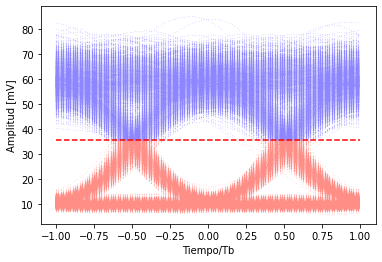

In [8]:
vm = np.mean(sk.KMeans(n_clusters=2).fit(ydata.reshape(-1,1)).cluster_centers_)

y_top = ydata[ydata>vm]*1e5
t_top = t[ydata>vm]
y_bot = ydata[ydata<vm]*1e5
t_bot = t[ydata<vm]

plot(t_top, y_top, '.', color='#8E86FF', markersize=.3, alpha=.5, label='mitad superior')
plot(t_bot, y_bot, '.', color='#FF8E86', markersize=.3, alpha=.5, label='mitad inferior')
plot([-1,1],[vm*1e5,vm*1e5], ls='--', color='r')
xlabel('Tiempo/Tb')
ylabel('Amplitud [mV]')
# savefig('Cp2-Diag-ojo-paso1.pdf', bbox_inches='tight')
show()

### Paso 2 - Determinar nivel superior e inferior a partir de sus intervalos más cortos

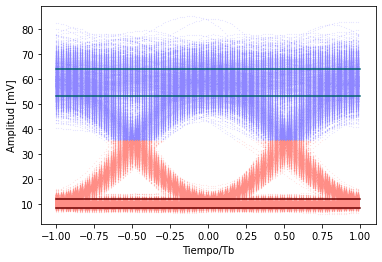

In [9]:
top_int = shorth_int(ydata[ydata>vm])
state_1 = np.mean(top_int)

bot_int = shorth_int(ydata[ydata<vm])
state_0 = np.mean(bot_int)

plot(t_top, y_top, '.', color='#8E86FF', markersize=.3, alpha=.5, label='mitad superior')
plot(t_bot, y_bot, '.', color='#FF8E86', markersize=.3, alpha=.5, label='mitad inferior')

plot([-1,1],np.ones(2)*top_int[0]*1e5, ls='-', color='#00626F')
plot([-1,1],np.ones(2)*top_int[1]*1e5, ls='-', color='#00626F')
plot([-1,1],np.ones(2)*bot_int[0]*1e5, ls='-', color='#6D0000')
plot([-1,1],np.ones(2)*bot_int[1]*1e5, ls='-', color='#6D0000')

xlabel('Tiempo/Tb')
ylabel('Amplitud [mV]')
# savefig('Cp2-Diag-ojo-paso2.pdf', bbox_inches='tight')
show()


### Paso 3 - Determinar los tiempos de cruce

Tiempo de bit: 1.0 Tb


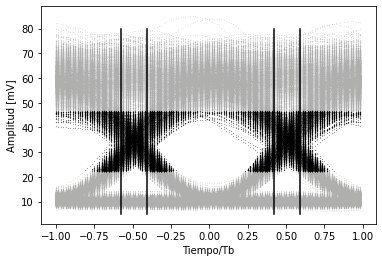

In [10]:
d01 = state_1 - state_0
v75 = state_1 - 0.25*d01
v25 = state_0 + 0.25*d01

tt = t[(ydata>v25)&(ydata<v75)]
y_tt = ydata[(ydata>v25)&(ydata<v75)]*1e5

ts = t[ydata>v75]
y_ts = ydata[ydata>v75]*1e5

ti = t[ydata<v25]
y_ti = ydata[ydata<v25]*1e5

tm = np.mean(sk.KMeans(n_clusters=2).fit(tt.reshape(-1,1)).cluster_centers_)
tt_left = tt[tt<tm]
t_left_int = shorth_int(tt_left)
t_left = find_nearest(t, np.mean(t_left_int))
y_tt_left = y_tt[tt<tm]

tt_right = tt[tt>tm]
t_right_int = shorth_int(tt_right)
t_right = find_nearest(t, np.mean(t_right_int))
y_tt_right = y_tt[tt>tm]

print('Tiempo de bit:', t_right-t_left, 'Tb')

plot(ts, y_ts, '.', color='#AFAFAE', markersize=.3, alpha=.7)
plot(ti, y_ti, '.', color='#AFAFAE', markersize=.3, alpha=.7)
plot(tt_left, y_tt_left, '.', color='k', markersize=.3, alpha=1)
plot(tt_right, y_tt_right, '.', color='k', markersize=.3, alpha=1)

plot(np.ones(2)*t_left_int[0],[5,80], color='k')
plot(np.ones(2)*t_left_int[1],[5,80], color='k')

plot(np.ones(2)*t_right_int[0],[5,80], color='k')
plot(np.ones(2)*t_right_int[1],[5,80], color='k')

# plot([-1,1], np.ones(2)*v25*1e5, 'r--')
# plot([-1,1], np.ones(2)*v75*1e5, 'r--')

xlabel('Tiempo/Tb')
ylabel('Amplitud [mV]')
# savefig('Cp2-Diag-ojo-paso3.pdf', bbox_inches='tight')
show()

### Paso 4 - Determinar la amplitud de cruce

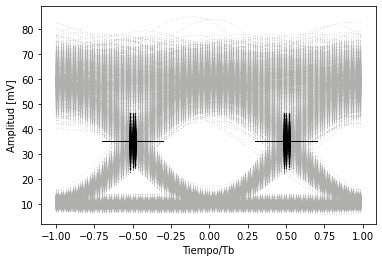

In [11]:
t_dist = t_right - t_left
tll = t_left - 0.02 * t_dist
thh = t_left + 0.02 * t_dist

amp_dat_l = ydata[((ydata < v75) & (ydata > v25)) & ((tll < t) & (t < thh))]
t_amp_dat_l = t[((ydata < v75) & (ydata > v25)) & ((tll < t) & (t < thh))]
ampx_l = np.mean(amp_dat_l)

tll = t_right - 0.02 * t_dist
thh = t_right + 0.02 * t_dist
amp_dat_r = ydata[((ydata < v75) & (ydata > v25)) & ((tll < t) & (t < thh))]
t_amp_dat_r = t[((ydata < v75) & (ydata > v25)) & ((tll < t) & (t < thh))]
ampx_r = np.mean(amp_dat_r)

ampx = find_nearest(ydata, (ampx_l + ampx_r)/2)

plot(t,ydata*1e5, '.', color='#AFAFAE', markersize=.3, alpha=.7)
plot(t_amp_dat_l, amp_dat_l*1e5, 'k.', markersize=.3, alpha=1)
plot(t_amp_dat_r, amp_dat_r*1e5, 'k.', markersize=.3, alpha=1)

plot([-.7,-.3], np.ones(2)*ampx*1e5, 'k', lw=1, markersize=.3, alpha=1)
plot([.3,.7], np.ones(2)*ampx*1e5, 'k', lw=1, markersize=.3, alpha=1)

xlabel('Tiempo/Tb')
ylabel('Amplitud [mV]')
# savefig('Cp2-Diag-ojo-paso4.pdf', bbox_inches='tight')
show()



### Paso 5 - Calcular el Jitter

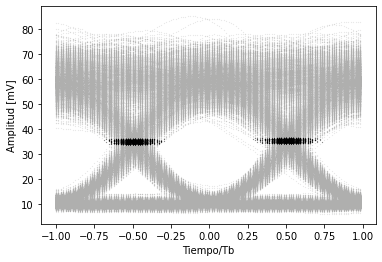

In [12]:
tll = t_left - 0.25 * t_dist
thh = t_left + 0.25 * t_dist

tj_l = t[((ampx_l - 0.02 * d01 < ydata) & (ydata < ampx_l + 0.02 * d01)) & ((tll < t) & (t < thh))]
y_tj_l = ydata[((ampx_l - 0.02 * d01 < ydata) & (ydata < ampx_l + 0.02 * d01)) & ((tll < t) & (t < thh))]
jitter_l = np.std(tj_l)

tll = t_right - 0.25 * t_dist
thh = t_right + 0.25 * t_dist

tj_r = t[((ampx_r - 0.02 * d01 < ydata) & (ydata < ampx_r + 0.02 * d01)) & ((tll < t) & (t < thh))]
y_tj_r = ydata[((ampx_r - 0.02 * d01 < ydata) & (ydata < ampx_r + 0.02 * d01)) & ((tll < t) & (t < thh))]
jitter_r = np.std(tj_r)

plot(t,ydata*1e5, '.', color='#AFAFAE', markersize=.3, alpha=.7)
plot(tj_l, y_tj_l*1e5, 'k.', markersize=.3, alpha=1)
plot(tj_r, y_tj_r*1e5, 'k.', markersize=.3, alpha=1)

xlabel('Tiempo/Tb')
ylabel('Amplitud [mV]')
# savefig('Cp2-Diag-ojo-paso5.pdf', bbox_inches='tight')
show()

### Paso 6 - Deteriminar valores medios y desviaciones estándar de los niveles 0 y 1 en el centro del ojo

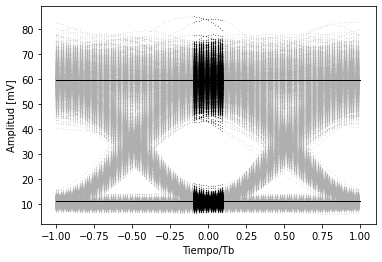

In [13]:
t_center = find_nearest(t, (t_left + t_right)/2)

t_dist = t_right - t_left
t_span0 = t_center - 0.1*t_dist
t_span1 = t_center + 0.1*t_dist

y_center = find_nearest(ydata, (state_0 + state_1)/2)

t_cluster1 = t[(ydata > y_center) & ((t_span0 < t) & (t < t_span1))]
cluster1 = ydata[(ydata > y_center) & ((t_span0 < t) & (t < t_span1))]
t_cluster0 = t[(ydata < y_center) & ((t_span0 < t) & (t < t_span1))]
cluster0 = ydata[(ydata < y_center) & ((t_span0 < t) & (t < t_span1))]

top_mean = np.mean(cluster1)
top_std = np.std(cluster1)
bot_mean = np.mean(cluster0)
bot_std = np.std(cluster0)

plot(t,ydata*1e5, '.', color='#AFAFAE', markersize=.3, alpha=.7)
plot(t_cluster1, cluster1*1e5, 'k.', markersize=.3, alpha=1)
plot(t_cluster0, cluster0*1e5, 'k.', markersize=.3, alpha=1)

plot([-1,1], np.ones(2)*top_mean*1e5, 'k-',lw=1)
plot([-1,1], np.ones(2)*bot_mean*1e5, 'k-',lw=1)

xlabel('Tiempo/Tb')
ylabel('Amplitud [mV]')
# savefig('Cp2-Diag-ojo-paso6.pdf', bbox_inches='tight')
show()

### Appendix - Calcular apertura y ancho del ojo 

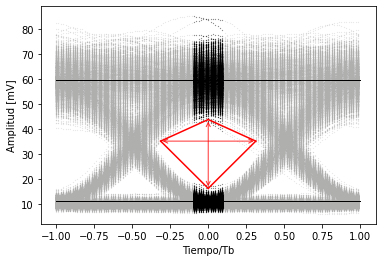

In [14]:
v_0130 = np.sort(cluster1)[int(len(cluster1)*0.0013)]
v_9987 = np.sort(cluster0)[int(len(cluster0)*0.9987)]
eye_h = v_0130 - v_9987

t_0130 = np.sort(tj_r)[int(len(tj_r)*0.0013)]
t_9987 = np.sort(tj_l)[int(len(tj_l)*0.9987)]
eye_w = t_0130 - t_9987


plot(t,ydata*1e5, '.', color='#AFAFAE', markersize=.3, alpha=0.7)
plot(t_cluster1, cluster1*1e5, 'k.', markersize=.3, alpha=1)
plot(t_cluster0, cluster0*1e5, 'k.', markersize=.3, alpha=1)

plot([-1,1], np.ones(2)*top_mean*1e5, 'k-',lw=1)
plot([-1,1], np.ones(2)*bot_mean*1e5, 'k-',lw=1)

# plot([-1,1], np.ones(2)*(top_mean-3*top_std)*1e5, 'k-',lw=1)
# plot([-1,1], np.ones(2)*(bot_mean+3*bot_std)*1e5, 'k-',lw=1)

# plot(np.ones(2)*t_0130, [5,90], 'k-',lw=1)
# plot(np.ones(2)*t_9987, [5,90], 'k-',lw=1)

plot([t_9987, t_center],[ampx*1e5,v_0130*1e5],'r')
plot([t_0130, t_center],[ampx*1e5,v_0130*1e5],'r')
plot([t_9987, t_center],[ampx*1e5,v_9987*1e5],'r')
plot([t_0130, t_center],[ampx*1e5,v_9987*1e5],'r')


annotate("",xy=(t_center, (v_0130)*1e5), xytext=(t_center, v_9987*1e5), arrowprops=dict(arrowstyle="<->", color="r", alpha=0.8))
annotate("",xy=(t_center-eye_w/2, ampx*1e5), xytext=(t_center+eye_w/2, ampx*1e5), arrowprops=dict(arrowstyle="<->", color="r", alpha=0.8))

xlabel('Tiempo/Tb')
ylabel('Amplitud [mV]')
# savefig('Cp2-Diag-ojo-mascara.pdf', bbox_inches='tight')
show()

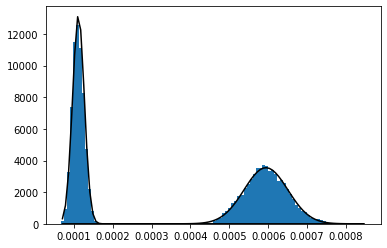

In [19]:
gaus = lambda x,mu,std: 1/std/(2*pi)**0.5*np.exp(-0.5*(x-mu)**2/std**2)
M = 2

cluster_01 = np.concatenate((cluster0,cluster1))

_,bins,_= hist(cluster_01, bins=100, density=True)
x = bins[:-1] + np.diff(bins)/2

plot(x, 1/M*gaus(x, top_mean, top_std), color = '#000000')
plot(x, (M-1)/M*gaus(x, bot_mean, bot_std), color = '#000000')
show()